In [1]:
# ANN OCR trained with Noise
# numpy/tensorflow/keras
#
# ICIN/IC Ex1 - Ago/2018 - Adolfo Bauchspiess 

import numpy as np

from keras.models import Sequential
from keras.models import clone_model
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib.lines as lines

import tensorflow as tf
import geraChar

from keras import backend as K

def swish(x):
    return K.sigmoid(x) * x


f= open("documentaTestes.txt","a+")
f.write("--------------- New Test ----------------\n")

N= 6  # Levels of noise
Nnt= 45# Number of training noise samples for each noise level
Nnv= 15# Number of validating noise samples
NStep= 10 # Noise step

f.write("Levels of noise %d\r\n" % N)
f.write("Number of training noise samples for each noise level %d\r\n" % Nnt)
f.write("Number of validating noise samples %d\r\n" % Nnv)

P=[]  # Pattern
T=[]  # Target
Pn=[] # Noise Pattern
fitT=np.zeros((N),dtype=int)  # Store the number of incorrect Chars while training
fitV=np.zeros((N),dtype=int)  # Store the number of incorrect Chars while training


Using TensorFlow backend.


Train networks


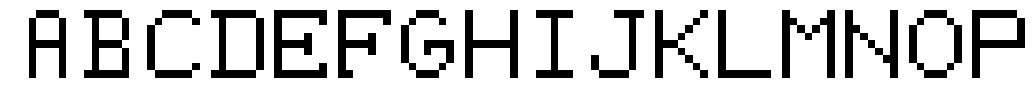

In [2]:
# create models with 0, 10, 20 .... 90% noisy bit
(P,T)=geraChar.geraChar()

# Creat a set of N ANNs
act1 = swish
NeuronsN = 32
Models=[]
for i in range(N): # for each model    
    model = Sequential()
    model.add(Dense(NeuronsN, activation= act1, kernel_initializer="uniform", input_dim=63))
    model.add(Dense(16, activation="sigmoid", kernel_initializer="uniform"))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    Models.append(model)
    
print("Train networks")
#f.write("Activation function =" + act1+"\n")
f.write("Number of Neurons in first layer %d\r\n" % NeuronsN)
epochsNoNoise = 200
f.write("Number of Epochs for no noise NN %d\r\n" % epochsNoNoise)
Models[0].fit(P, T, epochs=epochsNoNoise, batch_size=1, verbose=0)
f.write("weights of no noise trainging\n")
#f.write(Models[0].get_weights())
f.write("\n")
geraChar.showChar(P)

In [3]:
epochsSameNoise =100
epochsOtherNoise = 100
for i in range(1,N): # for each model
# Learn Nstep epochs Noise Chars + epochs reforcing orig. Chars.
                            
    # Mantain Models[i-1] and proceed training with noise
    Models[i].set_weights(Models[i-1].get_weights())
                            
    # test with different noise levels (at least once - range(i+1))
    for k in range(Nnt):
        Pn = geraChar.gchar_ruido(P,NStep*i)
        #geraChar.showChar(Pn)
        Models[i].fit(Pn, T, epochs=epochsSameNoise, batch_size=1, verbose=0)
        (incorr,idx) = geraChar.validacao(Pn,Models[i])
        fitT[i] += incorr
         
    #Pn = geraChar.gchar_ruido(P,0) # Reforce learning without noise 
    Models[i].fit(P, T, epochs=epochsOtherNoise, batch_size=1, verbose=0)
    (incorr,idx) = geraChar.validacao(P,Models[i])
    fitT[i] += incorr

    print("Rede i",i,"incorr",str(np.round(fitT[i],2)))
f.write("Number of Epochs for the same noise NN %d\r\n" % epochsSameNoise)
f.write("Number of Epochs for other noise NN %d\r\n" % epochsOtherNoise) 

('Rede i', 1, 'incorr', '1')
('Rede i', 2, 'incorr', '2')
('Rede i', 3, 'incorr', '24')
('Rede i', 4, 'incorr', '49')
('Rede i', 5, 'incorr', '122')


In [4]:
print(model.summary())
plot_model(model, to_file='model.png',show_shapes=True, show_layer_names=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 32)                2048      
_________________________________________________________________
dense_12 (Dense)             (None, 16)                528       
Total params: 2,576
Trainable params: 2,576
Non-trainable params: 0
_________________________________________________________________
None


('Test ANN trained with 0%, 10%,...  noise. % incorrect Chars = ', array([ 0.  ,  0.  ,  6.25,  6.25, 18.75, 43.75]))
('Test original (no noisy train) % incorrect Chars = ', array([ 0.  ,  0.  ,  6.25, 37.5 , 37.5 , 43.75]))


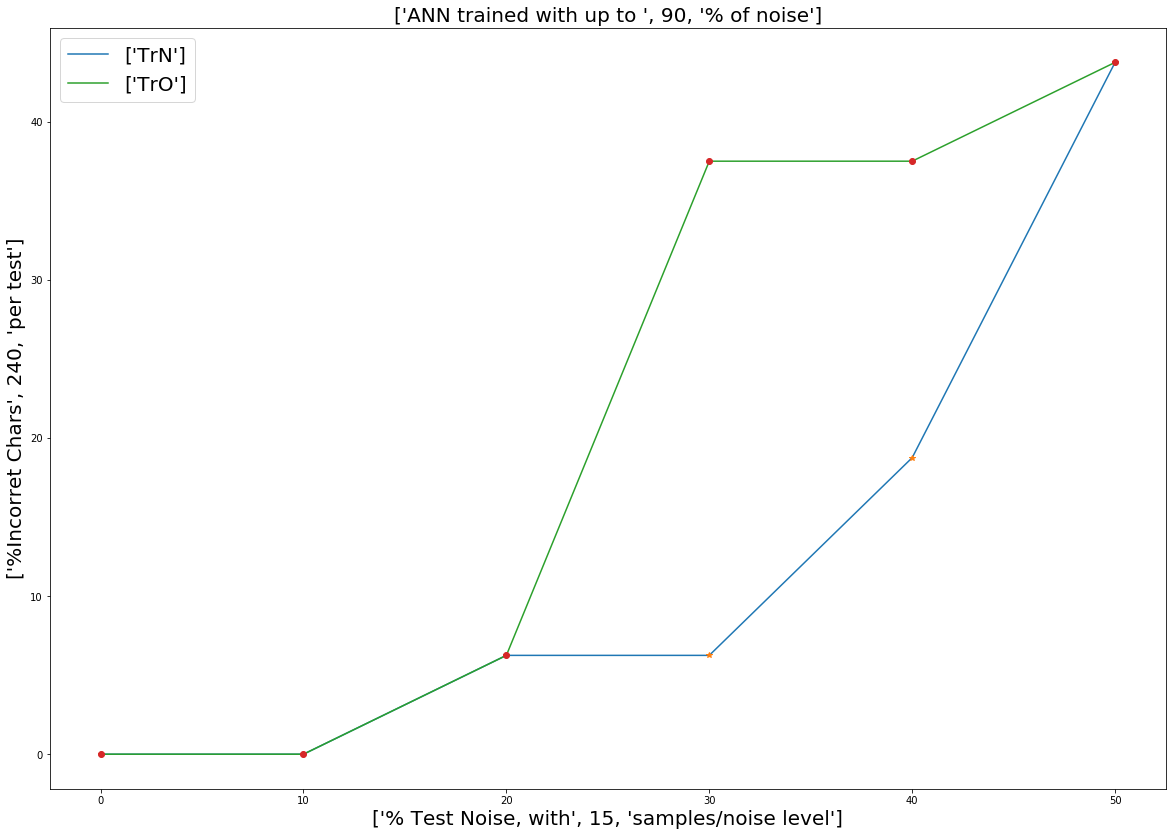

In [5]:
# Validate the trained ANN

fitV=np.zeros((N),dtype=float)
for i in range(N): # for each model
    for k in range(Nnv):
        Pn = geraChar.gchar_ruido(P,NStep*i)
        (incorr,idx) = geraChar.validacao(Pn,Models[i])
        fitV[i] += incorr
FitV=np.round(100*fitV/(16*Nnv),2)
#FITVSEpochs.append(FitV)

print("Test ANN trained with 0%, 10%,...  noise. % incorrect Chars = ",FitV)

fitO=np.zeros((N),dtype=float)
for i in range(N): # for each model
    for k in range(Nnv):
        Pn = geraChar.gchar_ruido(P,NStep*i)
        (incorr,idx) = geraChar.validacao(Pn,Models[0])
        fitO[i] += incorr
FitO=np.round(100*fitO/(16*Nnv),2)
#FITOSEpochs.append(FitO)

print("Test original (no noisy train) % incorrect Chars = ",FitO)



plt.figure(figsize=(20,14))
 
plt.plot(range(0,NStep*N,NStep),FitV, label=['TrN'])
plt.plot(range(0,NStep*N,NStep),FitV,'*')

plt.plot(range(0,NStep*N,NStep),FitO, label=['TrO'])
plt.plot(range(0,NStep*N,NStep),FitO,'o')

plt.title(['ANN trained with up to ' ,N*Nnv,'% of noise'], fontsize=20)
plt.ylabel(["%Incorret Chars",Nnv*16,'per test'], fontsize=20)
plt.xlabel(['% Test Noise, with',Nnv,'samples/noise level'], fontsize=20)
plt.legend(loc='upper left', fontsize=20)
 
plt.savefig('figANN.pdf')
plt.show()     